### Calibrate all floats that have oxygen data
*Create a local copy of Argo data, match it to World Ocean Atlas, and correct it to match climatology*

Use the `load_biofloat_cache.py` script to create a local cache file of all the data we want to work with:

```bash
load_biofloat_cache.py --age 365 --cache_dir /data/biofloat -v >> age365.out 2>&1 &
```

This script takes several days to complete and needs to be monitored as it depends on Internet resources which occaisonally fail to respond. The `load_biofloat_cache.py` can be killed and restarted as necessary to deal with these interruptions. We save the logger output to a log file (`age365.out`) to facilitate analysis of the data load. When this script was executed in November of 2015 it produced an 8.4 GB file (`biofloat_fixed_cache_age365.hdf`) which we can load and see how much oxygen data the file contains.

In [1]:
from biofloat import ArgoData
ad = ArgoData(cache_file='biofloat_fixed_cache_age365.hdf')

In [2]:
ocdf = ad.get_cache_file_oxy_count_df()
print ocdf.groupby('wmo').sum().sum()
print 'Float having DOXY_ADJUSTED data:', ocdf.wmo.count()
acdf = ad.get_cache_file_all_wmo_list()
print 'Number of floats examined:', len(acdf)

num_measurements    10510832
num_profiles           41828
dtype: int64
Float having DOXY_ADJUSTED data: 296
Number of floats examined: 558


That's over 10 million measurements from 41,828 profiles from 296 floats. The `load_biofloat_cache.py` script examined 558 floats for valid oxygen data. All of the profile data are in this file and the data from any float can be examined, e.g.:

In [4]:
%%time
wmo_list = ['5903612']
df = ad.get_float_dataframe(wmo_list)

CPU times: user 4.67 s, sys: 373 ms, total: 5.05 s
Wall time: 7.18 s


In [5]:
%pylab inline
import pylab as plt
from mpl_toolkits.basemap import Basemap

def map(lons, lats):
    m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
    m.fillcontinents(color='0.8')
    m.scatter(lons, lats, latlon=True, color='red')

Populating the interactive namespace from numpy and matplotlib


/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


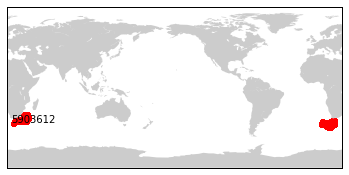

In [6]:
tdf = df.copy()
tdf['lon'] = tdf.index.get_level_values('lon')
tdf['lat'] = tdf.index.get_level_values('lat')
map(tdf.lon, tdf.lat)

for wmo, lon, lat in tdf.groupby(level='wmo')['lon', 'lat'].mean().itertuples():
    if lon < 0:
        lon += 360
    plt.text(lon, lat, wmo)

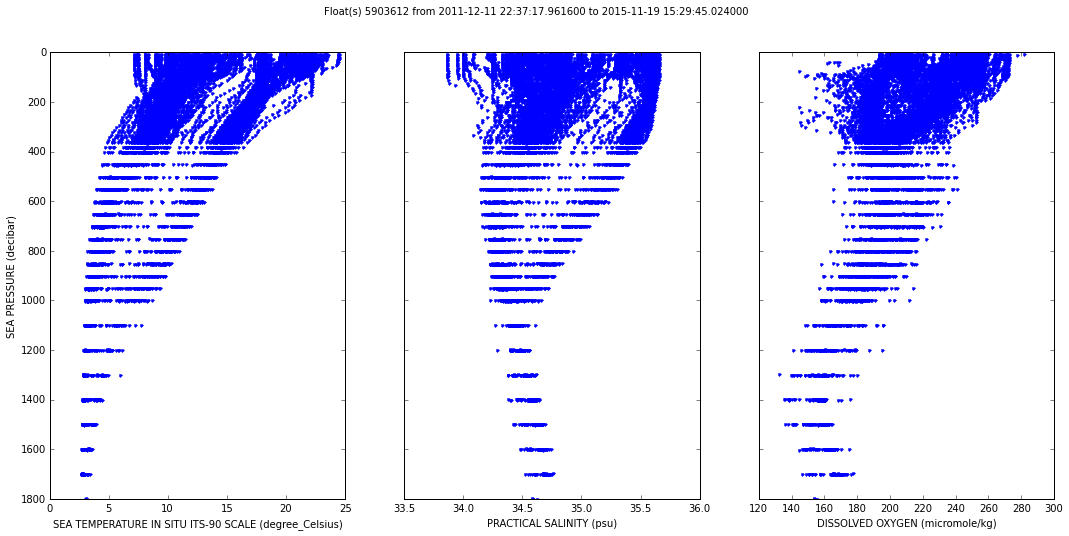

In [7]:
# Parameter long_name and units copied from attributes in NetCDF files
time_range = '{} to {}'.format(df.index.get_level_values('time').min(), 
                               df.index.get_level_values('time').max())
parms = {'TEMP_ADJUSTED': 'SEA TEMPERATURE IN SITU ITS-90 SCALE (degree_Celsius)', 
         'PSAL_ADJUSTED': 'PRACTICAL SALINITY (psu)',
         'DOXY_ADJUSTED': 'DISSOLVED OXYGEN (micromole/kg)'}

plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, len(parms), sharey=True)
ax[0].invert_yaxis()
ax[0].set_ylabel('SEA PRESSURE (decibar)')

for i, (p, label) in enumerate(parms.iteritems()):
    ax[i].set_xlabel(label)
    ax[i].plot(df[p], df.index.get_level_values('pressure'), '.')
    
plt.suptitle('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)